# COVID-19 Open Research Dataset Challenge (CORD-19)
### An AI challenge with AI2, CZI, MSR, Georgetown, NIH & The White House

##### Title: The “Bait-and-Fish” Method - A Novel AI-Powered Method for Discovering Hidden/Rare Topics in a Large Dataset using Unsupervised Machine Learning Techniques.
##### Focus: Application of the Novel “Bait-and-Fish” Method to Examining Socio-Economic and Policy Characteristics of Coronavirus Epidemics/Pandemics and Implications for Low- and Middle-Income Countries.


# **Methodology: Fish and Bait**
<div style=\"text-align: justify\"> 
The methodology developed to analyze the CORD-19 articles was done with the intent of replicating to any other semantic analysis regardless of the research area.
The concept lies on the existing text analysis technic using term frequency and inverse document frequency matrix (tf-idf) and then clustering documents based on the calculated distanced between them using Euclidian or Cosine distance. Our approach simply created a reference document with a set of keywords related to the field of interest, then to insert this reference document into the corpora before running the clustering algorithm that remains unsupervised.</div><p>

<div style=\"text-align: justify\"> 
After the cluster has converged, we identify the cluster in which the algorithm has placed our reference document and we focus on topic analysis within the Cluster. This technic helps reducing the dimension of the corpora (set of articles) and focus on discovering within the dataset.
In the case of the COVID-19 articles analysis, we will focus on discovering socio-economic impact and policies established to mitigate similar epidemic and pandemic situation.</div><p>

***Acknowledgement***: Work accomplished in collaboration with the MFONDOUM Center for community development: <b>Dr. yolande Pengetnze, MD, Mr. Roy MFONDOUM, MSc., Ms. Clemence CHINTOUO, BSc. Mr. Roland NGOUYAMSA MSc.</b>


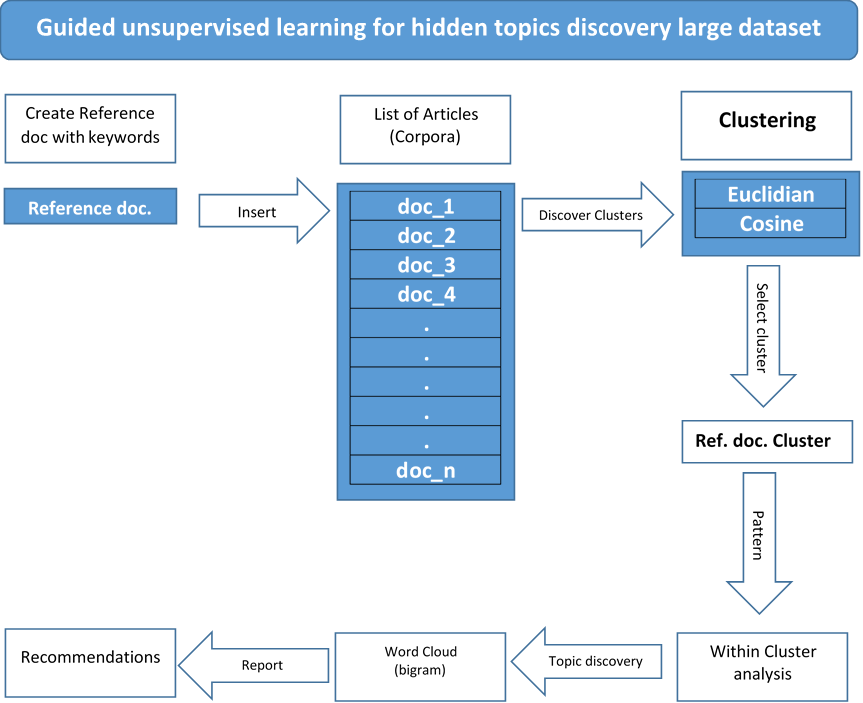

## <font color='blue'>Fish and bait steps:</font>

* step 1: Introduce a bait article into the dataset
* step 2: Attract similar articles in a Cluster around the bait articles using K-Mean and LDA
* step 3: Identify the cluster to which our bait was assign
* step 4: Extract articles from the cluster and remove the bait
* step 5: Vizualise the result using WordCloud
* step 6: Repeat all of the above until our baith keywords are part of the term frequency median
* step 7: Summarise the articles selected using BERT summariser or manual review depending on the final size of the Cluster

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from IPython.display import display, Markdown, Latex

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import pickle
import joblib
from sklearn.externals import joblib

import os
import math

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn.cluster import KMeans

## Exploratory analysis of the articles

We wll retrieve the articles here, and analyse the distribtions around their length.

In [ ]:
articles = pd.read_csv('../input/clean-and-steamed-corpus/articles_clean.csv' ,header='infer')
articles.head()

##### Articles length distribution

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.distplot(articles.length.apply(math.log))
ax.set(title='Histogram of the articles number of characters log transformed.',xlabel='Log of Article length', ylabel='Proportions')
plt.show()

print('There are in total {} articles containing a text body with their lengths normally distributed around the average length of: {} words.'.format(len(articles.length),round(np.mean(articles.length))))

## Step 1: Creating and introducing the bait or reference article

our bait is created with th intention of attracting all articles with specific keywords for:

* Understand reshaping population habits by mean of social distancing can help overcome the outbreak
* Capturing the Socio-economic impact of a medical outbreaks such as COVID-19
* find Policies related articles for better understanding policies put in place in the past that helped in similar situation
* Understand infrastructure requirements during such an outbreak

Hence below bait was created:

In [ ]:
refdoc = "Household Infrastructure Containment Ecological Historical Perception internalization financial support aide bailout policy policies politics social economic socioeconomic cultural technology Environment Confinement Stay-at-home Shelter-in-place Inequalities Iniquities Disparities Communication Mass communication Information Language barrier Propaganda Poverty Homelessness homeless Beliefs Religion religious Behaviors Education Educational achievement Access Health insurance Public transportation Food security insecurity stamp Housing instability Internet access Conspiracy theory Vulnerable populations Low-income Middle-income Social status Socioeconomic status Social aide Government aide Government subsidies Remote villages Churches Schools School closure Social distancing Physical distancing Utilities Abuse  Domectic violence Neighborhood Social safety Social determinants health Traditional medicine Traditions traditional Legal Law Prisons prisoner Underdeveloped countries Developed countries Health systems Race Ethnicity urban rural areas cities villages"
refdoc = refdoc.lower()

Before vectorizing, let's reduce the processing time and ensure that we do not get too many undesirable words, we will get read of all words shorted or equal to 5 letters and remove all numbers and special characters from our corpus.

In [ ]:
shortword = re.compile(r'\W*\b\w{1,5}\b')
subs=""

articles['article'] = articles['article'].map(lambda x: re.sub(shortword, subs, x))
articles['length'] = articles['article'].map(lambda x: len(x))

In [ ]:
refdf = pd.Series({'article':refdoc,'length':len(refdoc),'lang':'en'})

refdf=pd.DataFrame(refdf)
articles = pd.concat([refdf.T, articles], ignore_index=True)
articles.head()

Now that we have our bait(reference document) inserted in the row 0 of our corpora we can start the tokenization. 

## Step 2: Clustering articles around the bait

In this section we will:

* Prepare the dataset for clustering
* find similarity between existing articles and our reference articles using Clustering with KMeans. 

In [ ]:
#### Tokenising | Loading for speed of processing

tokenized_articles = articles['article'].apply(lambda x: x.split())

#### Removing English stopwords
stopwords = text.ENGLISH_STOP_WORDS

tokenized_articles = tokenized_articles.apply(lambda x: [i for i in x if i not in stopwords])

#### Stemming will help us reduce considerably the dimension of our idf by removing words repetitions due to grammar variations such as plural, conjugated words and so on.

stemmer = SnowballStemmer("english")

## Reading from prestemmed dataset
stemmed_articles = tokenized_articles.apply(lambda x: [stemmer.stem(token) for token in x])
#stemmed_articles = pd.read_csv('../input/moredata/',header='infer')

#### Detokenization

#### detokenization
detokenized_articles = []
for i in range(len(stemmed_articles)):
    if i in stemmed_articles:
        t = ' '.join(stemmed_articles[i])
        detokenized_articles.append(t)
        

#### Loading the detokenized words for faster processing.
with open('tokenized_articles.data', 'wb') as filehandle:
    # store the data as binary data stream
    tokenized_articles=pickle.load(filehandle)


#### Creating the Tf-idf to generate the document term natrix

In [ ]:

def preprocessor(tokens):
    r = re.sub( '(\d)+', '', tokens.lower() )
    return r

ngram_range=(1,3)

vectorizer = TfidfVectorizer(stop_words=stopwords,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=ngram_range)
  
### Vectorizing abstract series
cv = CountVectorizer( preprocessor=preprocessor, stop_words = stopwords,lowercase = True, ngram_range = ngram_range,max_features = 100 )

### Creating the bag of words | Reading instead of running
bow_articles = vectorizer.fit_transform(detokenized_articles)

### Getting the list of features from the bag of words
terms = vectorizer.get_feature_names()

In [ ]:
bow_articles = joblib.load('../input/nparrays/bow_articles.pkl')
print('We end-up with a bag of word in form of a matrix of {} unique words within {} documents in rows, ready to be clustered.'.format(bow_articles.shape[1], bow_articles.shape[0]))

In [ ]:
##### Using K-means Algorythm, we predefine 10 as the number of clusters for grouping documents.
num_clusters = 10

km = KMeans(n_clusters=num_clusters, n_jobs=10)
km.fit(bow_articles)

In [ ]:
## Loading pre-trained model
km = joblib.load('../input/models/km_compressed.pkl')

## Getting prediction
y_kmeans = km.predict(bow_articles)

### Getting the clusters
clusters = km.labels_.tolist()

## Step 3: Finding our bait cluster.

In [ ]:
clusters_articles = pd.Series(clusters).value_counts().sort_index()

clusters_info = pd.DataFrame({'ClusterId':list(clusters_articles.index),'Members':clusters_articles})

print('Discovered clusters Ids and membership counts:\n\n {}'.format(clusters_info))

plt.figure(figsize=(10,8))
ax = sns.barplot(x='ClusterId', y='Members', data=clusters_info)
#ax.set(xlim=(0,13000))
ax.set(xlabel='Clusters', ylabel='Membership')

plt.title('Histogram number of articles per cluster.', fontsize=20)

for index, row in clusters_info.iterrows():
    ax.text(row.ClusterId,row.Members, round(row.Members,0), color='black', ha="center")
    
plt.show()

We can see the distribution of clusters and the articles membership to them. Increasing the number of clusters may even reduce more the size of the clusters.

In [ ]:
### Plotting the cluster
centers = km.cluster_centers_

x=centers[:,0]
y=centers[:,1]

x=centers[:,0]
y=centers[:,1]

color=clusters_info['ClusterId']
size=clusters_info['Members']

plt.figure(figsize=(15, 10), dpi=80)

plt.scatter(np.log(x), np.log(y),  c=color, s=size, alpha=0.5, cmap = 'hsv')

plt.title('Clusters size and reference plot', fontsize=20)

# zip joins x and y coordinates in pairs
i=0
for a,b in zip(x,y):

    label = "Id {}: {}".format(clusters_info['ClusterId'][i],clusters_info['Members'][i])

    plt.annotate(label, # this is the text
                 (np.log(a),np.log(b)), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    i=i+1

plt.show()

### Getting clusters Ids associated to the documents Ids
df_clust = pd.DataFrame({'DocumentId':np.arange(0,len(y_kmeans),1),'ClusterId':y_kmeans})

print('Our bait document id is 0 hence will be displayed on the fisrt row of the below output with its cluster id')
df_clust.head()

## Summarized output
* The reference document at position 0 is found to be in the cluster id 0
* Cluster 0 contains 5438 documents that were attracted by the bait document 0.
* We have reduced by approximately 88% the size of our article pool down from 45000
* This is what th bait approach is about.

This process could be repeted iteratively until we get to the minimum size without loss of information.
Next: we will plot the wordcloud of our cluster 0 to see how relevant it is to the bait we used.

## Step 4: Cluster 0 articles filtering and analysis

We excluded the reference document from the cluster to make sure that the word list we introduced does not influence articles WordCloud outcome.

In [ ]:
indices = df_clust[df_clust['ClusterId']==0].index

In [ ]:
cluster0_corpus = [stemmed_articles[i] for i in indices if i!=0]

cluster0_corpus = pd.Series(cluster0_corpus)

cluster0_corpus.index=indices[1:]

### Verification of original dataframe indices for tracking articles.
cluster0_corpus.index

#### detokenization
detokenized_corpus0 = []

for i in range(len(cluster0_corpus)):
    if i in cluster0_corpus:
        t = ' '.join(cluster0_corpus[i])
        detokenized_corpus0.append(t)

In [ ]:
ngram_range=(2,2)

### Vectorizing abstract series
cv = CountVectorizer( preprocessor=preprocessor, stop_words = stopwords,lowercase = True, ngram_range = ngram_range, max_features = 500 )

### Creating the bag of words
bow_c0 = cv.fit_transform( detokenized_corpus0 ).todense()

### Getting Cluster0 list of features
features_c0 = cv.get_feature_names()

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

########################################################################
### Take the TF_IDF and converts it into a WordCloud object to be plotted
def WordCloud_covid(tfidf): 
    x = tfidf
    x[ 'word' ] = x.index
    dt_c0 = pd.Series( x.frequency, index = x.word.values ).to_dict()

    ##stopwords = set(STOPWORDS)


    ## plotting the word cloud
    wordcloud_c0 = WordCloud( 
        stopwords = stopwords_med,
        background_color = 'white',
        width = 5000,
        height = 3000,
        random_state = 40 ).generate_from_frequencies( dt_c0 )
    return(wordcloud_c0)

########################################################################

def WordCloudplot(wordcloud, size=(18,10)):
    plt.figure(figsize=size,facecolor = 'white', edgecolor='blue')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show();

### Functions for TFIDF and WordCloud

### This function generates the tfidf from the Bag of Words and the Features

def tfidf_covid19(bow_c0, features_c0):
    ### Creating the DF-ITF
    ## Building the documents term matrix in a dataframe
    df_dtm_c0 = pd.DataFrame( data = bow_c0, columns = features_c0 )

    ###################################################################
    ##
    ## Display the top words and their frequency.
    ## Find column sums and create a DataFrame.
    ##
    x = df_dtm_c0.sum( axis = 0 )
    df_tf_c0 = pd.DataFrame( { 'frequency':x } )
    ##
    ## Display the top five records.
    ##
    topn = df_tf_c0.nlargest( columns = 'frequency', n = 10 )

    # topn.style.set_caption( 'Top Ten Words' )
    ##
    ##
    ##
    ## Calculate the tf-idf weights.
    ##
    transformer = TfidfTransformer( norm = 'l2' )
    tfidf_mat_c0 = transformer.fit_transform( bow_c0 )
    data = np.round( tfidf_mat_c0.todense(), 3 )
    df_tfidf_c0 = pd.DataFrame( data = data, columns = features_c0 )
    ##
    ## Transforming the df_tfidf into a DataFrame
    ##
    x1 = df_tfidf_c0.sum( axis = 0 )
    df_tfidf_c0 = pd.DataFrame( { 'frequency':x1 } )
    
    return(df_tfidf_c0)


### Function for Exploratory Data Analysis on TF-IDF

def TfIdf_Stats(df_tfidf_c0):
    ### Descriptive statistics on TFIDF 
    
    global tfidf_mean,tfidf_median, tfidf_sd, conf_int95, conf_int64, iqr_low, iqr_high

    ### Printing the histogram of the word TFIDF
    display(Markdown('#### <font color=\'blue\'>Line plot of the TF-IDF of the corpus'))
    ## print('Line plot of the TF-IDF of the corpus \n\n')

    df_tfidf_c0.plot(rot=45, figsize=(12,6))
    # Add title and axis names
    plt.title('Term Frequency plot by n-grams', fontsize=14, color='blue')
    plt.xlabel('Expressions')
    plt.ylabel('TF-IDF')
    plt.show()

    ### Printing the histogram of the word TFIDF
    display(Markdown('#### <p><font color=\'blue\'>Histogram plot of the TF-IDF of n-grams in the corpus'))
    ## print('Histogram plot of the TF-IDF of n-grams in the corpus \n\n')

    df_tfidf_c0['frequency'].hist(bins=50, figsize=(15,5))
    # Add title and axis names
    plt.title('Histogram of Term Frequency', fontsize=20, color='blue')
    plt.xlabel('TF-IDF')
    plt.ylabel('Terms count')
    plt.show()

    ## investigating the Mean and confidence interval and median
    display(Markdown('#### <p><font color=\'blue\'>Investigating the Mean and confidence interval and median.'))
    tfidf_mean = np.log(df_tfidf_c0['frequency']).mean()
    ##
    tfidf_sd = np.log(df_tfidf_c0['frequency']).std()

    tfidf_median = np.log(df_tfidf_c0['frequency']).median()

    print('\n\n Words log(TFIDF) have a Mean of {:.2f}, Median of {:.2f} and Standard Deviation of {:.2f}:'.format(tfidf_mean, tfidf_median, tfidf_sd)+'\n\n')

    ## 95% confidence interval to the mean log(tfidf)
    conf_int95 = [round(tfidf_mean-2*tfidf_sd,2), round(tfidf_mean+2*tfidf_sd,2)]

    ## 64% confidence interval to the mean log(tfidf)
    conf_int64 = [round(tfidf_mean-tfidf_sd,2), round(tfidf_mean+tfidf_sd,2)]

    print('95% of the Word have their log(TFIDF) between [{}-{}]:'.format(conf_int95[0], conf_int95[1])+'\n\n')

    print('68% of the Word have their log(TFIDF) between [{}-{}]:'.format(conf_int64[0], conf_int64[1])+'\n\n')
    #
    ## investigating the Median and IQR (Robust Statistics)
    #
    display(Markdown('#### <p><font color=\'blue\'>Investigating the Median and IQR (Robust Statistics)'))

    iqr_low = np.log(df_tfidf_c0['frequency']).quantile(0.25)

    iqr_high = np.log(df_tfidf_c0['frequency']).quantile(0.75)

    print('IQR range of word log(TFIDF) is [{}-{}]:'.format(iqr_low, iqr_high)+'\n\n')

    ### Transforming and plotting the log transformed TFIDF
    display(Markdown('#### <p><font color=\'blue\'>Transforming and plotting the log transformed TFIDF'))
    
    np.log(df_tfidf_c0['frequency']).hist(bins=50, figsize=(15,5), alpha=0.7)
    
    # Add title and axis names
    plt.title('Log of Term Frequency plot by bigram', fontsize=14, color='blue')
    plt.axvline(x=conf_int95[0], color='r', linestyle='dashed', linewidth=1)
    plt.axvline(x=conf_int95[1], color='r', linestyle='dashed', linewidth=1)
    plt.axvline(x=conf_int64[0], color='g', linestyle='dashed', linewidth=1)
    plt.axvline(x=conf_int64[1], color='g', linestyle='dashed', linewidth=1)
    plt.xlabel('log(TF-IDF)')
    plt.ylabel('Terms count')
    plt.show()

    ### Plotting the different sections of the line plot of TFIDF
    display(Markdown('#### <p><font color=\'blue\'>Plotting the different sections of the line plot of TFIDF'))

    ### lower 25% of the TFIDF
    print('Plotting the lower 25% of TFIDF \n\n')
    df_tfidf_c0['frequency'][np.log(df_tfidf_c0['frequency'])<iqr_low].plot(rot=45, figsize=(15,10))
    plt.show()

    print('Plotting the TFIDF range between [25% 75%]\n\n')
    df_tfidf_c0['frequency'][(np.log(df_tfidf_c0['frequency'])<=iqr_low) | (np.log(df_tfidf_c0['frequency'])>=iqr_high)].plot(rot=45, figsize=(15,10))
    plt.show()

    print('Plotting the higher 75% of TFIDF \n\n')

    df_tfidf_c0['frequency'][np.log(df_tfidf_c0['frequency'])>iqr_high].plot(rot=45, figsize=(15,10));
    plt.show()
    
#####################################################
## Building the Bag of Words
#####################################################
def bow_gen(articles):
    
    ### Creating the bag of words
    bow_articles4 = vectorizer.fit_transform(articles)
    
    return(bow_articles4)

#####################################################
## Cleaning corpora of articles
#####################################################
def CleanText(articles):
    
    #### Tokenising
    
    tokenized_cluster4 = articles['article'].apply(lambda x: x.split())

    tokenized_cluster4 = tokenized_cluster4.apply(lambda x: [i for i in x if i not in stopwords])

    ### Stemming
    stemmed_cluster4 = tokenized_cluster4.apply(lambda x: [stemmer.stem(token) for token in x])


    ### Detokenizing
    #### detokenization
    detokenized_cluster4 = []
    for i in range(len(stemmed_cluster4)):
        if i in stemmed_cluster4:
            t = ' '.join(stemmed_cluster3[i])
            detokenized_cluster3.append(t)
    return(detokenized_cluster3)


#####################################################
## This function is used to plot a Kmean Cluster around centroids
## Plotting the cluster
## in this case model = km3 and prediction = y_means3
#####################################################
def ClusterPlot(model, prediction):
    
    clusters_v3 = model.labels_.tolist()

    clusters_v3_articles = pd.Series(clusters_v3).value_counts().sort_index()

    clusters_v3_articles

    clusters_v3_info = pd.DataFrame({'ClusterId':list(clusters_v3_articles.index),'Members':clusters_v3_articles})

    clusters_v3_info


    ### Plotting the cluster
    centers_v3 = model.cluster_centers_

    x3=centers_v3[:,0]
    y3=centers_v3[:,1]

    clusters_v3_info = pd.Series(prediction).value_counts().sort_index()
    clusters_v3_info=pd.DataFrame({'ClusterId':clusters_v3_info.index, 'Members':clusters_v3_info})
    clusters_v3_info


    ### Plotting the cluster
    centers_v3 = model.cluster_centers_

    plt.figure(figsize=(15, 10), dpi=80)

    plt.scatter(np.log(x3), np.log(y3),  c=color, s=s, alpha=0.5, cmap = 'hsv')

    plt.title('Clusters size and reference plot', fontsize=20)

    # zip joins x and y coordinates in pairs
    i=0
    for a3,b3 in zip(x3,y3):

        label = "Id {}: {}".format(clusters_v3_info['ClusterId'][i],clusters_v3_info['Members'][i])

        plt.annotate(label, # this is the text
                     (np.log(a3),np.log(b3)), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        i=i+1

    plt.show();

##### Calculating the new Term Frequency Inverse Document Frequency

Updating the stopwords with common medical words to remove them from the dataset.

In [ ]:
### Generating and sorting the TFIDF
df_tfidf_c0 = tfidf_covid19(bow_c0=bow_c0, features_c0=features_c0)

df_tfidf_c0 = df_tfidf_c0.sort_values('frequency')
###

In [ ]:
df_tfidf_c0 = joblib.load('../input/data002/df_tfidf_c0.pkl')

In [ ]:
morewords ='disease, diseases, disorder, symptom, symptoms, drug, drugs, problems, problem,prob, probs, med, meds,pill,  pills,  medicine,  medicines,  medication,  medications,  treatment,  treatments,  caps,  capsules,  capsule, tablet,  tablets,  tabs,  doctor,  dr,  dr.,  doc,  physician,  physicians,  test,  tests,  testing,  specialist, specialists, side-effect, side-effects, pharmaceutical, pharmaceuticals, pharma, diagnosis, diagnose, diagnosed, exam, challenge,  device,  condition,  conditions,  suffer,  suffering  ,suffered,  feel,  feeling,  prescription,  prescribe, prescribed, over-the-counter, ot'

print('Content of our reference document:\n\n {}'.format(morewords))

stemmer = SnowballStemmer("english")

morewords = morewords.replace(' ', '').split(',')

morewords = [stemmer.stem(token) for token in morewords]
morewords = set(morewords)

stopwords = text.ENGLISH_STOP_WORDS
stopwords_med = set(stopwords).union(morewords)

#### Exploratory data analysis on words TF-IDF

In [ ]:
TfIdf_Stats(df_tfidf_c0)

1- The green lines show the 64% confidence interval around the mean.

2- The red line represent the 95% confidence interval around the mean.

We will go for the 64% confidence interval at this stage to ensure we capture as many terms as possible.

# Step 5: WordCloud Visualization of the bait article cluster

#### Wordcloud of the upper 75% important words

In [ ]:
#wordcloud2 = WordCloud_covid(tfidf=df_tfidf_c0[np.log(df_tfidf_c0['frequency'])>conf_int64[1]])
## Testing IQR approach
wordcloud2 = WordCloud_covid(tfidf=df_tfidf_c0[np.log(df_tfidf_c0['frequency'])>iqr_high])

display(Markdown('#### <p><font color=\'blue\'>Wordcloud of the upper 75% important words'))

WordCloudplot(wordcloud2)

##### Wordcloud of the 25% to 75% range of important words

In [ ]:
## wordcloud3 = WordCloud_covid(tfidf=df_tfidf_c0[(np.log(df_tfidf_c0['frequency'])>=conf_int64[0])&(np.log(df_tfidf_c0['frequency'])<=conf_int64[1])])

wordcloud3 = WordCloud_covid(tfidf=df_tfidf_c0[(np.log(df_tfidf_c0['frequency'])>=iqr_low)&(np.log(df_tfidf_c0['frequency'])<=iqr_high)])

WordCloudplot(wordcloud3)

#### Wordcloud of the 25% less words in our list

In [ ]:
## wordcloud4 = WordCloud_covid(tfidf=df_tfidf_c0[(np.log(df_tfidf_c0['frequency'])<conf_int64[0])])
wordcloud4 = WordCloud_covid(tfidf=df_tfidf_c0[(np.log(df_tfidf_c0['frequency'])<iqr_low)])

## Generating the wordcloud
display(Markdown('#### <p><font color=\'blue\'>Wordcloud of the 25% less words in our list'))

WordCloudplot(wordcloud4)

## Summary
From the above wordlcoud generated from the 5438 filtered articles, we can clearly see that our bigrams (set of expressions with 2 wordS) generated have successfully aggregated the topics of interests indicated by the keywords set defined in our original reference document.

* The reference document was remove from the articles dataframe before generating the wordcloud to avoid contamination.
* The Document Term Frequency and inverse document Frequency matrix was analysed and was deviced into 3 blocks. 
    - A bloc with their term frequencies below the 1st quartile
    - A bloc with their term frequencies between the 1st(excluded) and the 4th quartile (excluded) also known as inter-quartile range
    - A bloc with their term frequencies above the 4th quartile. 
* A pattern clearly suggest that there are very few words below the lower quartile and above the higher quartile.
* Our hypothesis is that after the 1st fish and bait clustering execution, most of our keyword will be present in the lower-quartile as rare words given that these articles are mostly scientific and we are looking for Socio-Economic and policy relates terms.
* Wordplot of the lower quartile confirms our hypothesis as we can immediately spot terms such as: 
    - household member
    - Knoweledge attitude
    - economic social
    - effective prevention
    - high income countries
    - low income countries
    - health infrastructure
    - health program
    ...

# Step 7: Literature review based on subset of the bait cluster

## Topic: Effectiveness of social distancing

Based on the Wordcloud form the bottom 25% word frequencies of our cluster, we decided to go for the question:

### **Question: What is the impact effectiveness of social distancing in containing a pandemic?**

We will lockup these keywords in the original corpora of all articles and compare the output to the one of our reduced corpora from our Cluster 0 articles.

In [ ]:
original_text = pd.read_csv("original_text.csv")

articles_cluster0 = original_text.loc[indices,]

In [ ]:
### Loading original data and stored intermediary results

original_text = joblib.load('../input/originaldata/original_raw_data.pkl')

articles_cluster0 = joblib.load('../input/data001/articles_cluster0.pkl')


### Creating Search pattern

pat10=r'social distancing'
pat11=r'effectiveness'

### Rewritting the columns name
original_text.columns=['article', 'length', 'article1']
articles_cluster0.columns=['article']

In [ ]:
original_text.head()

In [ ]:
orig_match = original_text['article'][original_text['article'].apply(lambda x: re.search(pat10,str(x))).notnull()]
orig_count= orig_match[orig_match.apply(lambda x: re.search(pat11,str(x))).notnull()].count()

print("Number of articles with the keyword: social distancing effectiveness in the original pool of articles was: {}".format(orig_count))

In [ ]:
new_match = articles_cluster0['article'][articles_cluster0['article'].apply(lambda x: re.search(pat10,str(x))).notnull()]
social_dist = new_match[new_match.apply(lambda x: re.search(pat11,str(x))).notnull()]
new_count=new_match[new_match.apply(lambda x: re.search(pat11,str(x))).notnull()].count()

print("Number of articles with the keyword: social distancing effectiveness in sub-Cluster of our reference document is: {}".format(new_count))

Our cluster 0 has only 28 articles related otour question and we will focus on them to produce our literature review.

In [ ]:
original_filtered = original_text.loc[social_dist.index]['article1']
original_filtered

### Summary:
From 45000 articles down to 28 articles filtered by relevance using this clustering approach.

# Automated Literature review on the 28 articles

In [ ]:
import json

from pandas.io.json import json_normalize  

### Detection of the articles language
!pip install langdetect
from langdetect import detect

### Summarizer package
!pip install bert-extractive-summarizer
# pip install summarizer
from summarizer import Summarizer
!pip install langdetect

In [ ]:
model = Summarizer()

### **Here we summarize 5 of the 28 articles just to demonstrate their relevance to our topic of interest and to the words defined in our bait / reference document.**

In [ ]:
results = [model(x, max_length=160) for x in original_filtered[:5]]

### Top 5 content summaries

In [ ]:
[print('Article {} summary:\n\n {}'.format(results.index(i),i.capitalize())) for i in results]

# Conclusion:

<div style="text-align: justify">We can clearly see that by using this new method we named **Fish and Bait**  we were able not only reduce the size of the search scope to 28 articles but we finetuned the relevance of our research to articles discussing more the socio-economic aspects of the pandemic as well as the policy recommendations to contain the spread of the virus. Adding the document summarizer help to quickly proof the point as we can clearly see that the output summaries generated automatically by the algorythm are absoluty relevant to our research.

This method can be proven much more efficient than only using a simple term search from the begining as it returned 191 articles in which some may have mentioned the expression once while remaining focused on the scientific aspect of the research on the Corona virus. Getting them in the review list would be a perfect wast of time. The **Fish and Bait** approach automatically excluded them from the relevance give the words inserted in our bait.

This can be generalized to any topic of interest and pool of articles. It would simply be a matter of inserting a different bait with relevant keywords and the clustering will achieve the most relevant filtering and provide better results than a simple search.

The shortcoming of the **Fish and bait** method are the time it take to generate the cluster. We are currently testing it with other topics and with different clustering algorithm to set a benchmark and optimize the performance. This will be published in subsequent articles on Kaggle.</div>
